In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [23]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Instructions/Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [27]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

first_row = session.query(Measurement).first()
print(first_row.__dict__)

first_row = session.query(Station).first()
print(first_row.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7f83bc45b4d0>, 'tobs': 65.0, 'date': '2010-01-01', 'id': 1, 'station': 'USC00519397', 'prcp': 0.08}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7f83bc45f0d0>, 'station': 'USC00519397', 'latitude': 21.2716, 'longitude': -157.8168, 'name': 'WAIKIKI 717.2, HI US', 'id': 1, 'elevation': 3.0}


# Exploratory Climate Analysis

2017-08-23 00:00:00
2016-08-23 00:00:00
            Precipitation
Date                     
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28
2016-08-24           2.15
2016-08-24           1.45


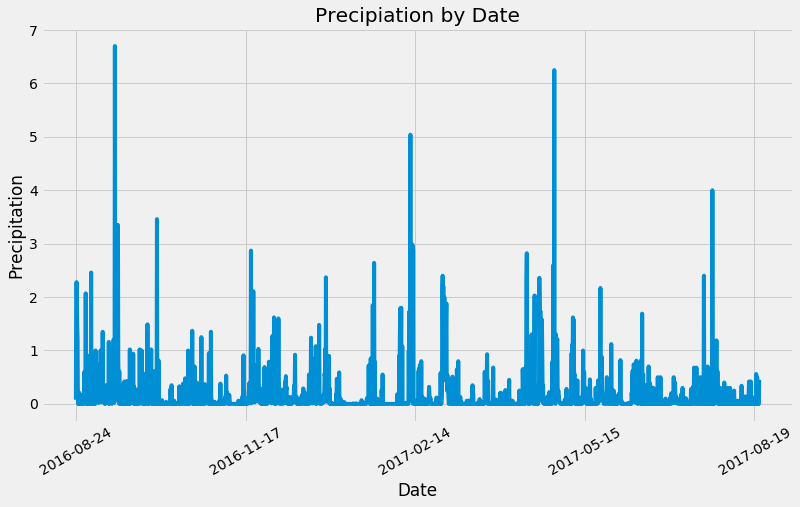

In [64]:
# Dates August 22 - September 5
from datetime import date
from dateutil import relativedelta

# Design a query to retrieve the last 12 months of precipitation data and plot the results
#today = date.today()
#twelve_months_ago = today - relativedelta.relativedelta(months=12)

#print(twelve_months_ago)
#precip = session.query(Measurement).filter_by(date > twelve_months_ago).filter_by(date <= today)

# Calculate the date 1 year ago from the last data point in the database
from sqlalchemy import desc
measurement = session.query(Measurement).order_by(desc(Measurement.date)).first()

recent_date = dt.datetime.strptime(measurement.date, '%Y-%m-%d')
year_ago = recent_date - relativedelta.relativedelta(years=1)

print(recent_date)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
measurements = session.query(Measurement).filter(Measurement.date > year_ago).filter(Measurement.date <= recent_date)
dates = []
prcps = []

for measurement in measurements:
    dates.append(measurement.date)
    prcps.append(measurement.prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
measure_df = pd.DataFrame({
    'Date': dates,
    'Precipitation': prcps
})


# Sort the dataframe by date
measure_df = measure_df.set_index('Date')
measure_df = measure_df.sort_values('Date')
measure_df = measure_df.dropna()
print(measure_df.head())

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
measure_df.plot(kind='line', ax=ax, grid=True, legend=False,
                title='Precipiation by Date')

plt.ylabel('Precipitation')
plt.xticks(rotation=30)

fig.set_size_inches(12, 6.75)
plt.savefig('Output/PrecipByDate.png')
plt.show()

In [65]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [66]:
# Design a query to show how many stations are available in this dataset?
stationcount = session.query(Station).count()
print(stationcount)

9


In [71]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_measurements = session.query(Measurement.station, func.Count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(desc(func.Count(Measurement.id))).all()
print(station_measurements)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [75]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = session.query(Measurement.station, func.Min(Measurement.tobs), func.Max(Measurement.tobs), func.Avg(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').\
    group_by(Measurement.station).all()
print(most_active)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
            Temperature
Date                   
2016-08-24         77.0
2016-08-25         80.0
2016-08-26         80.0
2016-08-27         75.0
2016-08-28         73.0


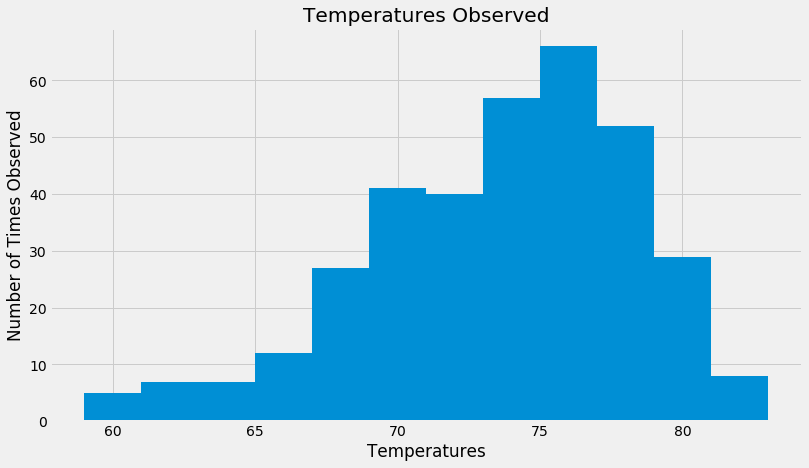

In [83]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temps = session.query(Measurement.station, func.Count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(desc(func.Count(Measurement.tobs))).all()
print(station_temps)

# Perform a query to retrieve the data and precipitation scores
measurements = session.query(Measurement).\
    filter(Measurement.station=='USC00519281').\
    filter(Measurement.date > year_ago).\
    filter(Measurement.date <= recent_date)
dates = []
temps = []

for measurement in measurements:
    dates.append(measurement.date)
    temps.append(measurement.tobs)

# Save the query results as a Pandas DataFrame and set the index to the date column
measure_df = pd.DataFrame({
    'Date': dates,
    'Temperature': temps
})


# Sort the dataframe by date
measure_df = measure_df.set_index('Date')
measure_df = measure_df.sort_values('Date')
measure_df = measure_df.dropna()
print(measure_df.head())

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
measure_df.plot(kind='hist', ax=ax, grid=True, legend=False, bins=12,
                title='Temperatures Observed')

plt.xlabel('Temperatures')
plt.ylabel('Number of Times Observed')
#plt.xticks(rotation=30)

fig.set_size_inches(12, 6.75)
plt.savefig('Output/TempByFrequency.png')
plt.show()

## Bonus Challenge Assignment

In [84]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [88]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2016-08-22', '2016-09-04')
print(trip_temps)

[(71.0, 78.20224719101124, 84.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
